In [22]:
pip install textblob

In [23]:
pip install vaderSentiment

In [24]:
pip install scikit-learn

In [25]:
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd
import matplotlib as plt
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
data_location = '/content/drive/MyDrive/SentimentAnalysis/ryanNewest.csv'
output_location = '/content/drive/MyDrive/SentimentAnalysis/'

In [41]:
data = pd.read_csv(data_location)
data["valence"] = (data["valence"] - 3) * -1

In [29]:
!python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 874.3 kB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [44]:
import spacy
import pandas as pd
import numpy as np
import json
import time
from collections import Counter
import re

# preprocessing steps (lakshays pipeline)
stopwords = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself',
             'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself',
             'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these',
             'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does',
             'did', 'doing', 'would', 'should', 'could', 'ought', 'i\'m', 'you\'re', 'he\'s', 'she\'s', 'it\'s', 'we\'re', 'they\'re',
             'i\'ve', 'you\'ve', 'we\'ve', 'they\'ve', 'i\'d', 'you\'d', 'he\'d', 'she\'d', 'we\'d', 'they\'d', 'i\'ll', 'you\'ll',
             'he\'ll', 'she\'ll', 'we\'ll', 'they\'ll', 'let\'s', 'that\'s', 'who\'s', 'what\'s', 'here\'s', 'there\'s', 'when\'s',
             'where\'s', 'why\'s', 'how\'s', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at',
             'by', 'for', 'with', 'about', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up',
             'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why',
             'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 'will', '\'s']

def lemmatizer(memory, model):
    # convert the memory given to tokenized sentence
    sentence = model(memory)

    # extract lemmatized form of all the tokens in the sentence
    # lemmata = [token.lemma_.lower() for token in sentence]
    lemmata = ['sing' if token.text.lower() == 'singing' else token.lemma_.lower()
               for token in sentence]  # tackling edge case since spacy model is lemmatizing 'singing' to 'singe' instead of 'sing'

    # join the lemmatized tokens to get the final lemmatized sentence
    final_sentence = ' '.join(lemmata)

    return final_sentence


def remove_stopwords(memory, stopwords):

    # Tokenize the memory (split into words)
    words = memory.lower().split()

    # Filter out stopwords
    filtered_words = [word for word in words if word not in stopwords]

    # Reconstruct the cleaned text
    cleaned_memory = ' '.join(filtered_words)

    return cleaned_memory


def find_custom_stopwords(memories_list):

    # combine all memories together to get custom stopwords
    memories = ' '.join(memories_list)

    # tokenize the combined memories
    tokens = memories.split()

    # count the frequency of each token and store it
    token_counts = Counter(tokens)
    frequencies = np.array(list(token_counts.values()))
    # print('frequency: ', sorted(frequencies, reverse=True),
    #       len(frequencies), np.sum(frequencies))
    mean_freq = np.mean(frequencies)  # mean of the frequency of tokens
    std_freq = np.std(frequencies)  # SD of the frequency of tokens

    # threshold of computing the custom stopwords is set to MEAN + 4*SD
    threshold = mean_freq + 4 * std_freq

    custom_stopwords = {word for word, count in token_counts.items()
                        if count > threshold}
    # Output results
    print(f"Token Frequencies (only showing Mean + 1 SD = {np.int32(mean_freq+std_freq)} tokens for now):",
          token_counts.most_common(np.int32(mean_freq+std_freq)))
    # print("Token Frequencies:", token_counts)
    print("Mean Frequency:", mean_freq)
    print("Standard Deviation:", std_freq)
    print('Threshold Frequency (Mean + 4 SDs): ', threshold)
    print("Custom Stopwords (4 SDs above mean):", custom_stopwords)

    return custom_stopwords


def remove_puncuation(memory):

    # Regex pattern to match all punctuation marks
    pattern = r"[^\w\s]"

    # Remove all punctuation marks
    memory_no_punctuation = re.sub(pattern, "", memory)

    return memory_no_punctuation


def preprocessing_pipeline(memories_list, stopwords):

    model = spacy.load(f'en_core_web_lg')

    print('\n\t\t >>>>>> STARTING PREPROCESSING STEPS <<<<<<\n\n')
    start = time.time()

    # 1. lemmatizing works good + lowering also done
    print("Step 1:: Starting lemmatization!\n")
    memories_list = [lemmatizer(memory, model) for memory in memories_list]

    # 2. now check for stopwords and remove the one's from snowball stopwords list
    print("Step 2:: Removing snowball stopwords (without negators and including 's token)!\n")
    memories_list = [remove_stopwords(memory, stopwords)
                     for memory in memories_list]

    # 3. remove all the punctuation marks now
    print("Step 3:: Removing punctuation marks!\n")
    memories_list = [remove_puncuation(memory) for memory in memories_list]

    # 4. now check for custom stopwords based on words occuring >3SDs away
    print("Step 4:: Finding custom stopwords!")
    custom_stopwords = find_custom_stopwords(memories_list)

    # 5. remove the custom stopwords now
    print("\nStep 5:: Removing custom stopwords now!\n")
    memories_list = [remove_stopwords(memory, custom_stopwords)
                     for memory in memories_list]

    print('FINAL:: Total time taken for all the preprocessing: ', time.time()-start)

    return memories_list


data["memory_processed"] = preprocessing_pipeline(data["memory"], stopwords)

/usr/local/lib/python3.11/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)



		 >>>>>> STARTING PREPROCESSING STEPS <<<<<<


Step 1:: Starting lemmatization!

Step 2:: Removing snowball stopwords (without negators and including 's token)!

Step 3:: Removing punctuation marks!

Step 4:: Finding custom stopwords!
Token Frequencies (only showing Mean + 1 SD = 44 tokens for now): [('memory', 1005), ('not', 651), ('time', 606), ('friend', 601), ('remember', 554), ('go', 403), ('feel', 393), ('school', 326), ('year', 320), ('think', 314), ('event', 309), ('get', 294), ('family', 255), ('one', 243), ('thing', 238), ('happen', 237), ('come', 235), ('back', 234), ('make', 223), ('day', 218), ('say', 207), ('like', 203), ('just', 190), ('mind', 188), ('something', 187), ('experience', 183), ('pop', 182), ('see', 177), ('first', 177), ('talk', 171), ('play', 161), ('past', 160), ('recollection', 156), ('take', 152), ('boyfriend', 149), ('person', 148), ('good', 141), ('often', 141), ('life', 140), ('moment', 137), ('walk', 134), ('relationship', 130), ('someone', 128), (

In [45]:
# Helper functions that we'll use

# Returns a 3 class score
# Is symmetric
def polarity_score(score: float, sentiment_threshold: float):
    if score > sentiment_threshold:
        return 1
    elif score < (-1 * sentiment_threshold):
        return -1
    else:
        return 0

# Returns a 3 class score, but allows asymmetric thresholds
# n is the negative threshold and p is positive one
def asymmetricPolarity(a, n, p):
  polarities = []
  for x in a:
    if x > p:
      polarities.append(1)
    elif x < n:
      polarities.append(-1)
    else:
      polarities.append(0)
  return polarities

# Returns a 5 class score
# Is symmetric
def fiveClass_score(score, lower, upper):
  if score > upper:
    return 2
  elif score > lower:
    return 1
  elif score >= -1*lower:
    return 0
  elif score >= -1*upper:
    return -1
  elif score >= -1.0:
    return -2

# Wrapper function that applies fiveClass_score to an array
def fcScore_list(a, lb, ub):
  out = []
  for x in a:
    out.append(fiveClass_score(x, lb, ub))
  return out

# Essentially polarity score, but with no threshold
def mySign(x):
  if x > 0:
    return 1
  elif x < 0:
    return -1
  else:
    return 0

# Wrapper function for mySign
def getSigns(a):
  out = []
  for i in a:
    out.append(mySign(i))
  return out

In [46]:
# Initializes a vader sentiment analyzer
analyzer = SentimentIntensityAnalyzer()


# The goal of this block is to create columns in our dataframe correspondingg
# to the memory's vader and Textblob score. We also create reference columns
# with the true valence scores for 3 and 5 class comparisons

# Initializing empty lists that track for each memory
vScores = []
tbScores = []
real3 = []
real5 = []
# Iterating through all the memories in the dataframe
for curMem in range(data.shape[0]):
  # Get the current memory
  memory = data['memory_processed'][curMem]
  # Create a textBlob for it
  currentBlob = TextBlob(memory)
  # Appending the scores we want to track
  tbScores.append(currentBlob.sentiment[0])
  vScores.append(analyzer.polarity_scores(memory)['compound'])
  real3.append(mySign(data['valence'][curMem]))
  real5.append(data['valence'][curMem])

# Adding the scores we've tracked to the dataframe
data["tbScores"] = tbScores
data["vScores"] = vScores
data["real3"] = real3
data["real5"] = real5

# An example of what the data looks like now.
data.head(10)

,deidentified_id_code,memory,valence,Word_Count,memory_processed,tbScores,vScores,real3,real5
0,1,I was at a work event and I was laughing to th...,-2,25,work laugh point eye start water uncontrollabl...,-0.100000,-0.1280,-1,-2
1,2,An argument with my parents regarding their ma...,-1,11,argument parent regard marriage kid,0.000000,-0.3612,-1,-1
2,3,mother locking me inside of house and trying t...,-2,30,mother lock inside house try end life alcohol ...,0.000000,-0.2960,-1,-2
3,4,2 popular girls that I became friends with in ...,-2,50,2 popular girl become junior high bully good k...,0.365000,-0.7351,-1,-2
4,5,"I was abused and have ptsd, I have reoccurring...",-2,29,abuse ptsd reoccurre regard head emotionally v...,0.000000,-0.8555,-1,-2
5,6,I was in montreal with my friends and I got in...,-1,58,montreal fight leave club late night phone dea...,-0.166667,-0.8689,-1,-1
6,8,my memory isn't a pleasant one and seems to al...,-2,53,pleasant seem always whenever uncomfortable sl...,0.035417,0.0496,-1,-2
7,9,"A student on campus told me to ""slit my wrists...",-2,29,student campus tell slit wrist send pic often ...,0.000000,0.0000,-1,-2
8,11,What would happen if I never stopped dancing? ...,-1,20,never stop dance ouch team technique sloppy,-0.416667,0.2235,-1,-1
9,12,I was in a car accident in grade 12 and I some...,-2,52,car accident grade 12 sometimes accident recur...,0.400000,-0.9100,-1,-2


In [47]:


# Helper Function to create a subset of the data
def mySubset(ds, size, seed):
  np.random.seed(seed)
  idx = np.random.choice(ds.shape[0], size)
  return ds.iloc[idx,:]


# 3 Class Threshold Analysis function
def threeClassTA(ds):
  tbScores = ds["tbScores"]
  vScores = ds["vScores"]
  real3 = ds["real3"]

  positiveThresholds = np.arange(0.00, 1, 0.01)
  negativeThresholds = np.arange(0.00, 1, 0.01) * -1

  tbMCC = []
  vMCC = []
  pT = []
  nT = []
  for p in positiveThresholds:
    for n in negativeThresholds:
      tbScored = asymmetricPolarity(tbScores, n, p)
      vScored = asymmetricPolarity(vScores, n, p)

      pT.append(p)
      nT.append(n)

      tbMCC.append(metrics.matthews_corrcoef(real3, tbScored))
      vMCC.append(metrics.matthews_corrcoef(real3, vScored))

  return pd.DataFrame({'PositiveThresholds': pT, 'NegativeThresholds': nT, 'TextBlobMCC': tbMCC, 'VADERMCC': vMCC})



# 5 Class Threhsold Analysis Function
def fiveClassTA(ds):
  tbScores = ds["tbScores"]
  vScores = ds["vScores"]
  real5 = ds["real5"]

  lowerbounds = np.arange(0.00, 1, 0.01)

  tbMCC = []
  vMCC = []
  lbT = []
  ubT = []
  for lb in lowerbounds:
    upperbounds = np.arange(lb+0.01, 1, 0.01)
    for ub in upperbounds:
      tbScored = fcScore_list(tbScores, lb, ub)
      vScored = fcScore_list(vScores, lb, ub)

      lbT.append(lb)
      ubT.append(ub)

      tbMCC.append(metrics.matthews_corrcoef(real5, tbScored))
      vMCC.append(metrics.matthews_corrcoef(real5, vScored))

  return pd.DataFrame({'Lowerbounds': lbT, 'Upperbounds': ubT, 'TextBlobMCC': tbMCC, 'VADERMCC': vMCC})

# Makes the MCC heat plots
# ds3 is the 3classTA ds
# ds5 is the 5classTA ds
def heatPlots(ds3, ds5):
  plt.subplot(2,2,1)
  plt.scatter(ds3["PositiveThresholds"], ds3["NegativeThresholds"], c = ds3["VADERMCC"], s = 2, linewidth = 2, cmap = "coolwarm")
  clb = plt.colorbar()
  clb.ax.set_title(' MCC', size = 7)
  plt.title("Vader MCC Scores")
  plt.xlabel("Positive Threshold")
  plt.ylabel("Negative Threshold")

  plt.subplot(2,2,2)
  plt.scatter(ds3["PositiveThresholds"], ds3["NegativeThresholds"], c = ds3["TextBlobMCC"], s = 2, linewidth = 2, cmap = "coolwarm")
  clb = plt.colorbar()
  clb.ax.set_title(' MCC', size = 7)
  plt.title("TextBlob MCC Scores")
  plt.xlabel("Positive Threshold")


  plt.subplot(2,2,3)
  plt.scatter(ds5["Lowerbounds"], ds5["Upperbounds"], c = ds5["VADERMCC"], s = 2, linewidth = 2, cmap = "coolwarm")
  clb = plt.colorbar()
  clb.ax.set_title(' MCC', size = 7)
  plt.xlabel("Lowerbounds")
  plt.ylabel("Upperbounds")

  plt.subplot(2,2,4)
  plt.scatter(ds5["Lowerbounds"], ds5["Upperbounds"], c = ds5["TextBlobMCC"], s = 2, linewidth = 2, cmap = "coolwarm")
  clb = plt.colorbar()
  clb.ax.set_title(' MCC', size = 7)
  plt.xlabel("Lowerbounds")
  plt.subplots_adjust(hspace = .3, wspace = .3)

  plt.show()



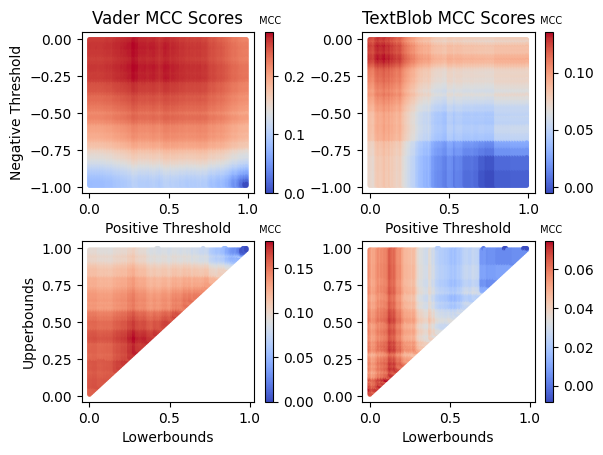

In [59]:
# Full Threshold Analysis

out3 = threeClassTA(data)
out5 = fiveClassTA(data)

heatPlots(out3, out5)

In [60]:
print("Best 3-Class Thresholds - VADER: Positive: ", np.round(out3["PositiveThresholds"][out3["VADERMCC"].argmax()], 2), " Negative: ", np.round(out3["NegativeThresholds"][out3["VADERMCC"].argmax()], 2))
print("Best 3-Class Thresholds - TextBlob: Positive: ", np.round(out3["PositiveThresholds"][out3["TextBlobMCC"].argmax()], 2), " Negative: ", np.round(out3["NegativeThresholds"][out3["TextBlobMCC"].argmax()], 2))
print("Best 5-Class Thresholds - Vader: Lowerbound: ", np.round(out5["Lowerbounds"][out5["VADERMCC"].argmax()], 2), " Upperbound: ", np.round(out5["Upperbounds"][out5["VADERMCC"].argmax()], 2))
print("Best 5-Class Thresholds - TextBlob: Lowerbounds: ", np.round(out5["Lowerbounds"][out5["TextBlobMCC"].argmax()], 2), " Upperbound: ", np.round(out5["Upperbounds"][out5["TextBlobMCC"].argmax()], 2))

Best 3-Class Thresholds - VADER: Positive:  0.28  Negative:  -0.18
Best 3-Class Thresholds - TextBlob: Positive:  0.1  Negative:  -0.14
Best 5-Class Thresholds - Vader: Lowerbound:  0.28  Upperbound:  0.39
Best 5-Class Thresholds - TextBlob: Lowerbounds:  0.1  Upperbound:  0.11


In [61]:
print("MCC of Best 3-Class Thresholds - VADER: ", out3["VADERMCC"][out3["VADERMCC"].argmax()])
print("MCC of Best 3-Class Thresholds - TextBlob: ", out3["TextBlobMCC"][out3["TextBlobMCC"].argmax()])
print("MCC of Best 5-Class Thresholds - VADER: ", out5["VADERMCC"][out5["VADERMCC"].argmax()])
print("MCC of Best 5-Class Thresholds - TextBlob: ", out5["TextBlobMCC"][out5["TextBlobMCC"].argmax()])

MCC of Best 3-Class Thresholds - VADER:  0.27485858833792987
MCC of Best 3-Class Thresholds - TextBlob:  0.13550101189608693
MCC of Best 5-Class Thresholds - VADER:  0.18067318991265677
MCC of Best 5-Class Thresholds - TextBlob:  0.07448145902499613


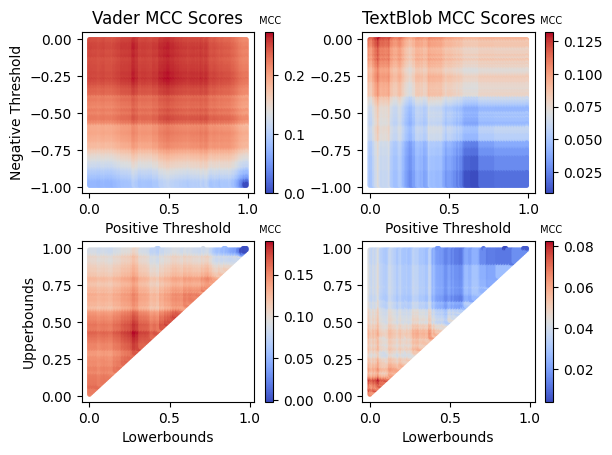

In [48]:
# Ablation analysis on ~75% (1800 samples)
subset = mySubset(data, 1800, 75)

out3 = threeClassTA(subset)
out5 = fiveClassTA(subset)

heatPlots(out3, out5)

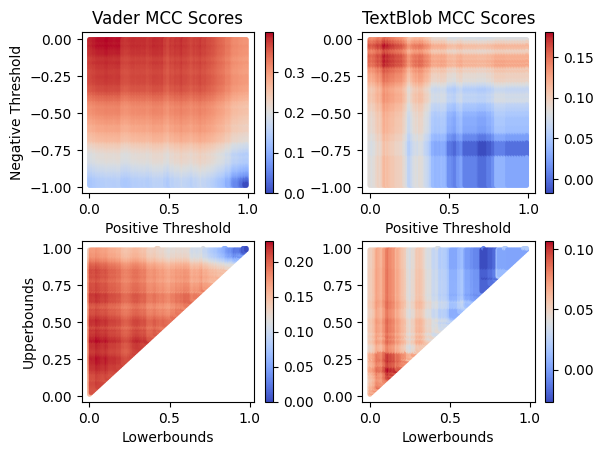

In [ ]:
# Ablation analysis on ~50% (1200 samples)
subset = mySubset(data, 1200, 50)

out3 = threeClassTA(subset)
out5 = fiveClassTA(subset)

heatPlots(out3, out5)

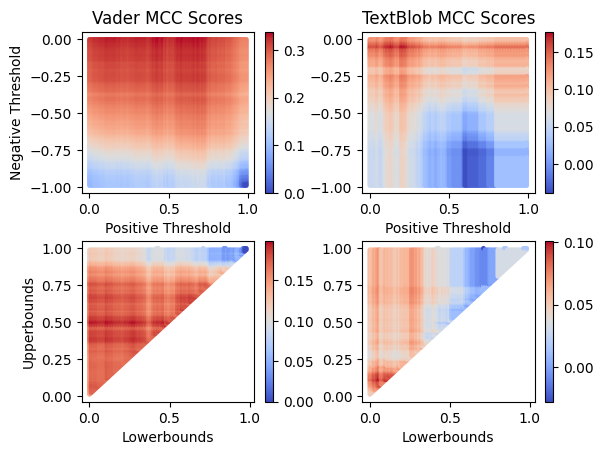

In [ ]:
# Ablation analysis on ~33% (826 samples) - Also matching Khalil Dataset
subset = mySubset(data, 826, 33)

out3 = threeClassTA(subset)
out5 = fiveClassTA(subset)

heatPlots(out3, out5)

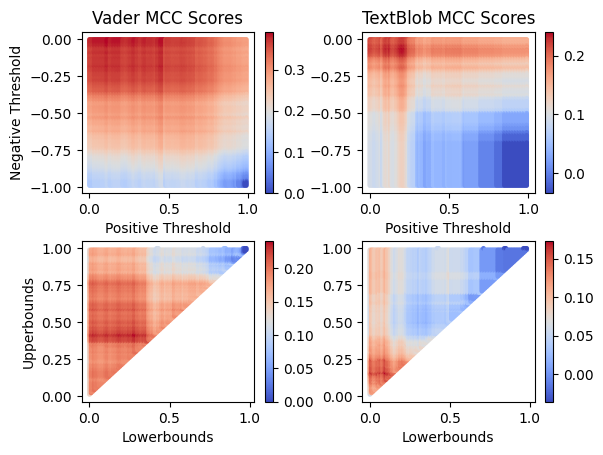

In [ ]:
# Ablation analysis on ~20% (500 samples)
subset = mySubset(data, 500, 20)

out3 = threeClassTA(subset)
out5 = fiveClassTA(subset)

heatPlots(out3, out5)

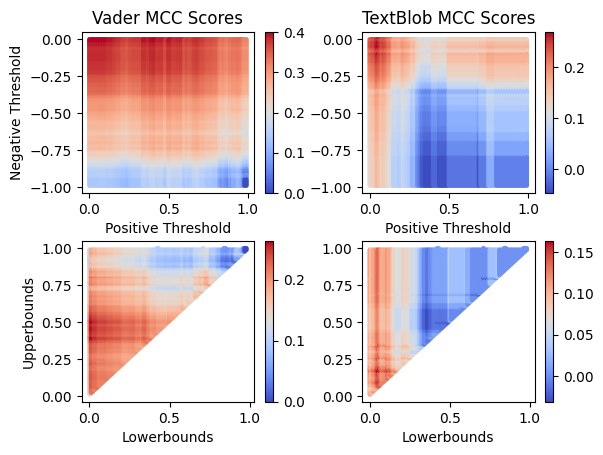

In [ ]:
# Ablation analysis on ~10% (250 samples)
subset = mySubset(data, 250, 10)

out3 = threeClassTA(subset)
out5 = fiveClassTA(subset)

heatPlots(out3, out5)

Ablation Analysis for MCC of the original thresholds

In [49]:
# useful functions

def threeClassMCC(scores, real, st):
  preds = []
  for s in scores:
    preds.append(polarity_score(s, st))
  return metrics.matthews_corrcoef(preds, real)

def fiveClassMCC(scores, real, lb, ub):
  preds = fcScore_list(scores, lb, ub)
  return metrics.matthews_corrcoef(preds, real)

def averageMCCs(ds, size, samples):
  tbMCCs_3c = []
  vMCCs_3c = []
  tbMCCs_5c = []
  vMCCs_5c = []
  for i in range(samples):
    subset = mySubset(ds, size, i)
    tbScores = subset["tbScores"]
    vScores = subset["vScores"]
    real3 = subset["real3"]
    real5 = subset["real5"]
    tbMCCs_3c.append(threeClassMCC(tbScores, real3, 0.01))
    vMCCs_3c.append(threeClassMCC(vScores, real3, 0.01))
    tbMCCs_5c.append(fiveClassMCC(tbScores, real5, 0.2, 0.6))
    vMCCs_5c.append(fiveClassMCC(vScores, real5, 0.2, 0.6))

  out = pd.DataFrame({"TextBlobMCCs_3c" : tbMCCs_3c,
                      "VaderMCCs_3c" : vMCCs_3c,
                      "TextBlobMCCs_5c" : tbMCCs_5c,
                      "VaderMCCs_5c" : vMCCs_5c})

  print("Average 3-Class MCC - TextBlob: ", np.mean(out["TextBlobMCCs_3c"]))
  print("Average 3-Class MCC - Vader: ", np.mean(out["VaderMCCs_3c"]))
  print("Average 5-Class MCC - TextBlob: ", np.mean(out["TextBlobMCCs_5c"]))
  print("Average 5-Class MCC - Vader: ", np.mean(out["VaderMCCs_5c"]))

  return out

In [50]:
# Calculating MCC on ~75% (1800 samples) of the data for original thresholds
out75 = averageMCCs(data, 1800, 50)


Average 3-Class MCC - TextBlob:  0.12162999125067708
Average 3-Class MCC - Vader:  0.2585541817158081
Average 5-Class MCC - TextBlob:  0.056234063942106255
Average 5-Class MCC - Vader:  0.13631690918063244


In [51]:
# Calculating MCC on ~50% (1200 samples) of the data for original thresholds
out50 = averageMCCs(data, 1200, 50)

Average 3-Class MCC - TextBlob:  0.12238309685155975
Average 3-Class MCC - Vader:  0.2593980932091844
Average 5-Class MCC - TextBlob:  0.05805597788666197
Average 5-Class MCC - Vader:  0.1340387605473043


In [52]:

# Calculating MCC on ~33% (825 samples) of the data for original thresholds
out33 = averageMCCs(data, 825, 50)

Average 3-Class MCC - TextBlob:  0.12118568195376202
Average 3-Class MCC - Vader:  0.25747363950675195
Average 5-Class MCC - TextBlob:  0.05685308261319438
Average 5-Class MCC - Vader:  0.13304713821118302


In [53]:
# Calculating MCC on ~20% (500 samples) of the data for original thresholds
out20 = averageMCCs(data, 500, 50)

Average 3-Class MCC - TextBlob:  0.12431290387820314
Average 3-Class MCC - Vader:  0.2644573490794653
Average 5-Class MCC - TextBlob:  0.056123542681127125
Average 5-Class MCC - Vader:  0.13542623059980502


In [54]:
# Calculating MCC on ~10% (250 samples) of the data for original thresholds
out10 = averageMCCs(data, 250, 50)

Average 3-Class MCC - TextBlob:  0.12328698256346378
Average 3-Class MCC - Vader:  0.26508347972199897
Average 5-Class MCC - TextBlob:  0.05441666145715251
Average 5-Class MCC - Vader:  0.13442584753011858


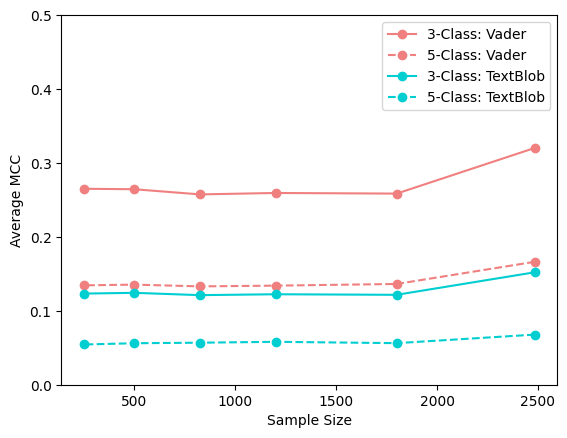

In [55]:
tb3c = [0.1521, np.mean(out75["TextBlobMCCs_3c"]), np.mean(out50["TextBlobMCCs_3c"]), np.mean(out33["TextBlobMCCs_3c"]), np.mean(out20["TextBlobMCCs_3c"]), np.mean(out10["TextBlobMCCs_3c"])]
v3c = [0.3203, np.mean(out75["VaderMCCs_3c"]), np.mean(out50["VaderMCCs_3c"]), np.mean(out33["VaderMCCs_3c"]), np.mean(out20["VaderMCCs_3c"]), np.mean(out10["VaderMCCs_3c"])]
tb5c = [0.0678, np.mean(out75["TextBlobMCCs_5c"]), np.mean(out50["TextBlobMCCs_5c"]), np.mean(out33["TextBlobMCCs_5c"]), np.mean(out20["TextBlobMCCs_5c"]), np.mean(out10["TextBlobMCCs_5c"])]
v5c = [0.1663, np.mean(out75["VaderMCCs_5c"]), np.mean(out50["VaderMCCs_5c"]), np.mean(out33["VaderMCCs_5c"]), np.mean(out20["VaderMCCs_5c"]), np.mean(out10["VaderMCCs_5c"])]
sampleSize = [2484, 1800, 1200, 825, 500, 250]

plt.plot(sampleSize, v3c, color='lightcoral', marker='o', label = "3-Class: Vader")
plt.plot(sampleSize, v5c, color='lightcoral', linestyle='dashed', marker='o', label = "5-Class: Vader")
plt.plot(sampleSize, tb3c, color='darkturquoise', marker='o', label = "3-Class: TextBlob")
plt.plot(sampleSize, tb5c, color='darkturquoise', linestyle='dashed', marker='o', label = "5-Class: TextBlob")
plt.xlabel("Sample Size")
plt.ylabel("Average MCC")
plt.ylim([0, 0.5])
plt.legend()

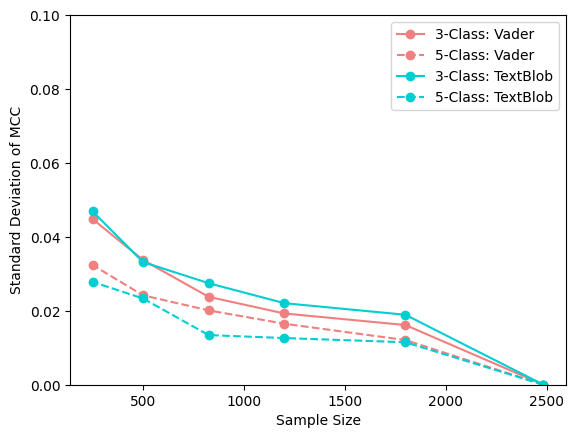

In [56]:
tb3c = [0, np.std(out75["TextBlobMCCs_3c"]), np.std(out50["TextBlobMCCs_3c"]), np.std(out33["TextBlobMCCs_3c"]), np.std(out20["TextBlobMCCs_3c"]), np.std(out10["TextBlobMCCs_3c"])]
v3c = [0, np.std(out75["VaderMCCs_3c"]), np.std(out50["VaderMCCs_3c"]), np.std(out33["VaderMCCs_3c"]), np.std(out20["VaderMCCs_3c"]), np.std(out10["VaderMCCs_3c"])]
tb5c = [0, np.std(out75["TextBlobMCCs_5c"]), np.std(out50["TextBlobMCCs_5c"]), np.std(out33["TextBlobMCCs_5c"]), np.std(out20["TextBlobMCCs_5c"]), np.std(out10["TextBlobMCCs_5c"])]
v5c = [0, np.std(out75["VaderMCCs_5c"]), np.std(out50["VaderMCCs_5c"]), np.std(out33["VaderMCCs_5c"]), np.std(out20["VaderMCCs_5c"]), np.std(out10["VaderMCCs_5c"])]
sampleSize = [2484, 1800, 1200, 825, 500, 250]





plt.plot(sampleSize, v3c, color='lightcoral', marker='o', label = "3-Class: Vader")
plt.plot(sampleSize, v5c, color='lightcoral', linestyle='dashed', marker='o', label = "5-Class: Vader")
plt.plot(sampleSize, tb3c, color='darkturquoise', marker='o', label = "3-Class: TextBlob")
plt.plot(sampleSize, tb5c, color='darkturquoise', linestyle='dashed', marker='o', label = "5-Class: TextBlob")
plt.xlabel("Sample Size")
plt.ylabel("Standard Deviation of MCC")
plt.ylim([0, 0.1])
plt.legend()

In [57]:
khDataLoc = '/content/drive/MyDrive/SentimentAnalysis/LLM/khalilNewest.csv'
khData = pd.read_csv(khDataLoc)

In [58]:
khData["memory_processed"] = preprocessing_pipeline(khData["Memory_text"], stopwords)

/usr/local/lib/python3.11/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)



		 >>>>>> STARTING PREPROCESSING STEPS <<<<<<


Step 1:: Starting lemmatization!

Step 2:: Removing snowball stopwords (without negators and including 's token)!

Step 3:: Removing punctuation marks!

Step 4:: Finding custom stopwords!
Token Frequencies (only showing Mean + 1 SD = 35 tokens for now): [('song', 860), ('remember', 298), ('friend', 236), ('listen', 228), ('remind', 227), ('play', 224), ('time', 146), ('school', 134), ('think', 128), ('hear', 126), ('go', 115), ('one', 114), ('not', 103), ('music', 101), ('use', 97), ('summer', 94), ('tiktok', 91), ('come', 91), ('first', 90), ('video', 90), ('sing', 90), ('watch', 89), ('memory', 87), ('radio', 84), ('dance', 84), ('car', 83), ('also', 82), ('like', 81), ('drive', 79), ('make', 79), ('popular', 71), ('lot', 56), ('get', 56), ('just', 54), ('see', 53)]
Mean Frequency: 6.781507283090564
Standard Deviation: 28.776283467322227
Threshold Frequency (Mean + 4 SDs):  121.88664115237947
Custom Stopwords (4 SDs above mean): {'remi

In [ ]:
# Initializes a vader sentiment analyzer
analyzer = SentimentIntensityAnalyzer()


# The goal of this block is to create columns in our dataframe correspondingg
# to the memory's vader and Textblob score. We also create reference columns
# with the true valence scores for 3 and 5 class comparisons

# Initializingg empty lists that track for each memory
vScores = []
tbScores = []
real3 = []
real5 = []
# Iterating through all the memories in the dataframe
for curMem in range(khData.shape[0]):
  # Get the current memory
  memory = khData['memory_processed'][curMem]
  # Create a textBlob for it
  currentBlob = TextBlob(memory)
  # Appending the scores we want to track
  tbScores.append(currentBlob.sentiment[0])
  vScores.append(analyzer.polarity_scores(memory)['compound'])
  real3.append(mySign(khData['Valence'][curMem] - 3))
  real5.append(khData['Valence'][curMem] - 3)

# Adding the scores we've tracked to the dataframe
khData["tbScores"] = tbScores
khData["vScores"] = vScores
khData["real3"] = real3
khData["real5"] = real5

# An example of what the data looks like now.
khData.head(10)

,Memory_text,Song,Singer,Year,Condition,Memory_year,Valence,Subject,Word Count,memory_processed,tbScores,vScores,real3,real5
0,driving back from walmart with my ex in his mw...,Save Your Tears,Ariana Grande,2021,Lyrics,2022.0,1,60,18,drive back walmart ex mwhim blast music headache,0.000000,0.0000,-1,-2
1,heard it on tiktok edits in 2021. Also remembe...,Stay,The Kid LAROI,2022,Music,2021.0,1,61,21,tiktok edit 2021 also outside summer 2021 typi...,-0.150000,0.0000,-1,-2
2,An old roommate used to listen to this song so...,Heat Waves,Glass Animals,2022,Music,2022.0,1,46,17,old roommate use bad memory,-0.300000,-0.5423,-1,-2
3,I have been through a heartbreak and I have a ...,Without Me,Halsey,2019,Name,2022.0,1,76,34,heartbreak playlist variety general theme,0.050000,-0.5719,-1,-2
4,remember this playing all the time over the sp...,Memories,Maroon 5,2020,Name,2021.0,1,59,19,speaker last job hate much,-0.200000,-0.5719,-1,-2
5,I was going through a breakup and was playing ...,Good 4 U,Olivia Rodrigo,2021,Name,0.0,1,2,11,go breakup,0.000000,0.0000,-1,-2
6,Felt very displeased listening to this song. I...,7 Rings,Ariana Grande,2019,Song,2023.0,1,34,29,felt displeased listening radio never enjoy re...,-0.300000,-0.7980,-1,-2
7,I was in discord with my friends when somebody...,Save Your Tears,Ariana Grande,2021,Song,2022.0,1,29,11,discord somebody,0.000000,-0.4019,-1,-2
8,I listened to this song a lot after breaking u...,Drivers License,Olivia Rodrigo,2021,Song,2022.0,1,6,16,lot break one ex girlfriend,0.000000,0.0000,-1,-2
9,Walking to my classes early in the morning bef...,Stay,The Kid LAROI,2022,Song,2023.0,1,43,49,walk class early morning first period bell rin...,0.016667,-0.3947,-1,-2


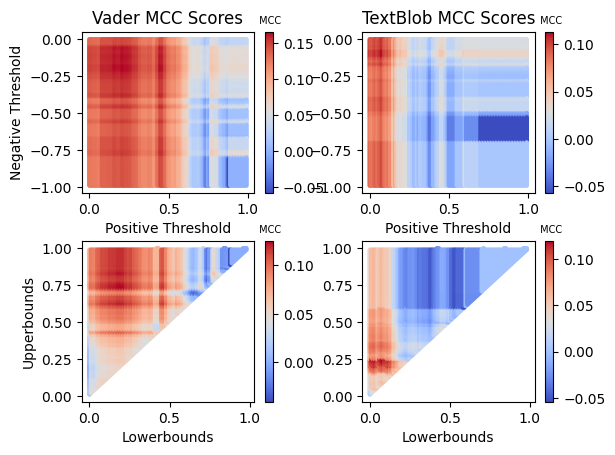

In [ ]:
# Ablation analysis on ~75% (615 samples)
subset = mySubset(khData, 615, 75)

out3 = threeClassTA(subset)
out5 = fiveClassTA(subset)

heatPlots(out3, out5)

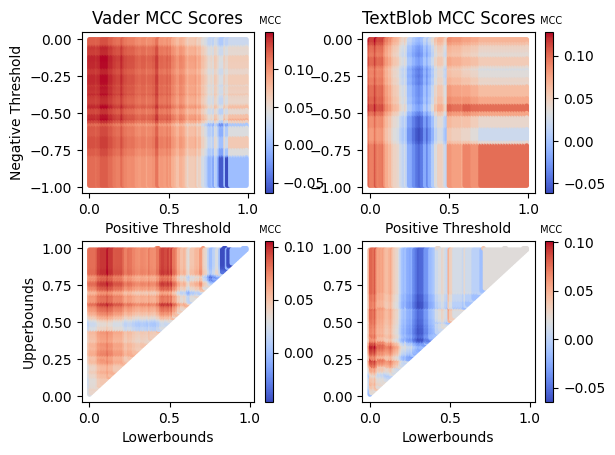

In [ ]:
# Ablation analysis on ~50% (410 samples)
subset = mySubset(khData, 410, 50)

out3 = threeClassTA(subset)
out5 = fiveClassTA(subset)

heatPlots(out3, out5)

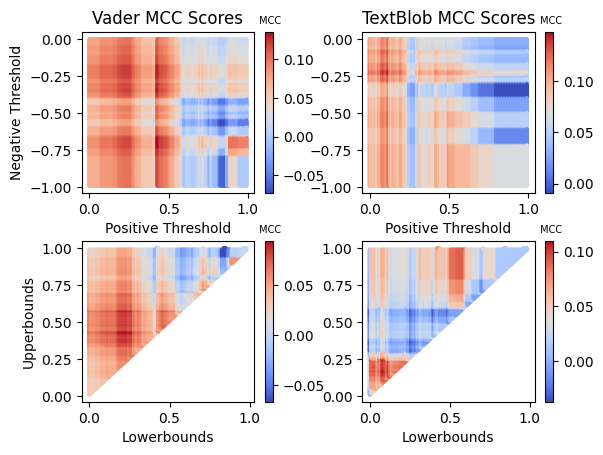

In [ ]:
# Ablation analysis on ~33% (275 samples)
subset = mySubset(khData, 275, 33)

out3 = threeClassTA(subset)
out5 = fiveClassTA(subset)

heatPlots(out3, out5)

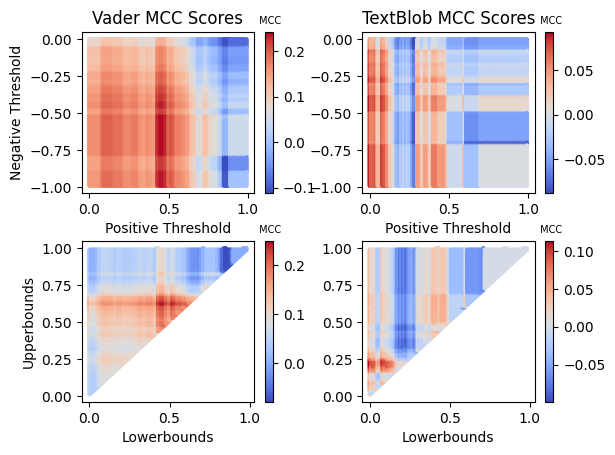

In [ ]:
# Ablation analysis on ~20% (160 samples)
subset = mySubset(khData, 160, 20)

out3 = threeClassTA(subset)
out5 = fiveClassTA(subset)

heatPlots(out3, out5)

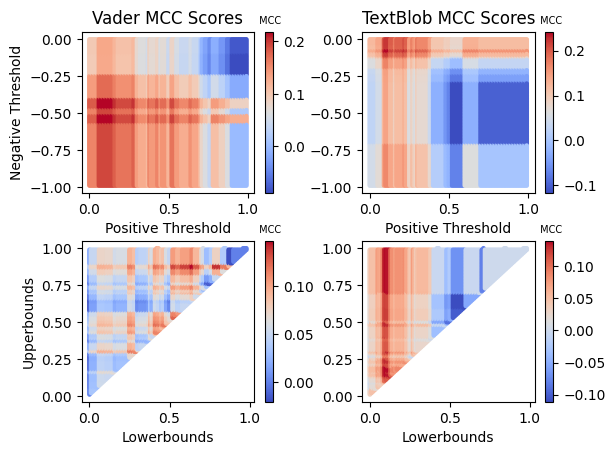

In [ ]:
# Ablation analysis on ~10% (82 samples)
subset = mySubset(khData, 82, 10)

out3 = threeClassTA(subset)
out5 = fiveClassTA(subset)

heatPlots(out3, out5)

In [ ]:
# Calculating MCC on ~75% (615 samples) of the data for original thresholds
out75 = averageMCCs(khData, 615, 50)

Average 3-Class MCC - TextBlob:  0.05840892478544997
Average 3-Class MCC - Vader:  0.11084120659785804
Average 5-Class MCC - TextBlob:  -0.019379536839864993
Average 5-Class MCC - Vader:  0.09108671526096168


In [ ]:
# Calculating MCC on ~50% (410 samples) of the data for original thresholds
out50 = averageMCCs(khData, 410, 50)

Average 3-Class MCC - TextBlob:  0.06063759379337058
Average 3-Class MCC - Vader:  0.11230005379523243
Average 5-Class MCC - TextBlob:  -0.020269985424548848
Average 5-Class MCC - Vader:  0.09459374716132371


In [ ]:
# Calculating MCC on ~33% (275 samples) of the data for original thresholds
out33 = averageMCCs(khData, 275, 50)

Average 3-Class MCC - TextBlob:  0.06349242090755379
Average 3-Class MCC - Vader:  0.11203442961611022
Average 5-Class MCC - TextBlob:  -0.019187292103499894
Average 5-Class MCC - Vader:  0.09253446914695453


In [ ]:
# Calculating MCC on ~20% (160 samples) of the data for original thresholds
out20 = averageMCCs(khData, 160, 50)

Average 3-Class MCC - TextBlob:  0.06744159284055992
Average 3-Class MCC - Vader:  0.11454828048506963
Average 5-Class MCC - TextBlob:  -0.021610693357640848
Average 5-Class MCC - Vader:  0.09153227796930537


In [ ]:
# Calculating MCC on ~10% (82 samples) of the data for original thresholds
out10 = averageMCCs(khData, 82, 50)

Average 3-Class MCC - TextBlob:  0.062323495426023084
Average 3-Class MCC - Vader:  0.1062059850664448
Average 5-Class MCC - TextBlob:  -0.02012101856575853
Average 5-Class MCC - Vader:  0.08148224603050332


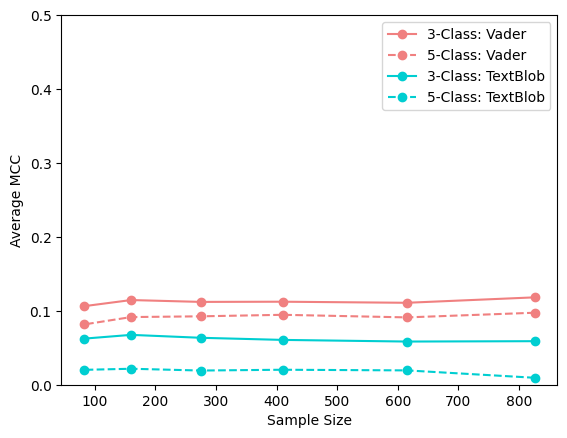

In [ ]:
tb3c = [0.0589, np.mean(out75["TextBlobMCCs_3c"]), np.mean(out50["TextBlobMCCs_3c"]), np.mean(out33["TextBlobMCCs_3c"]), np.mean(out20["TextBlobMCCs_3c"]), np.mean(out10["TextBlobMCCs_3c"])]
v3c = [0.1182, np.mean(out75["VaderMCCs_3c"]), np.mean(out50["VaderMCCs_3c"]), np.mean(out33["VaderMCCs_3c"]), np.mean(out20["VaderMCCs_3c"]), np.mean(out10["VaderMCCs_3c"])]
tb5c = np.array([-0.0094, np.mean(out75["TextBlobMCCs_5c"]), np.mean(out50["TextBlobMCCs_5c"]), np.mean(out33["TextBlobMCCs_5c"]), np.mean(out20["TextBlobMCCs_5c"]), np.mean(out10["TextBlobMCCs_5c"])]) * -1
v5c = [0.0974, np.mean(out75["VaderMCCs_5c"]), np.mean(out50["VaderMCCs_5c"]), np.mean(out33["VaderMCCs_5c"]), np.mean(out20["VaderMCCs_5c"]), np.mean(out10["VaderMCCs_5c"])]
sampleSize = [826, 615, 410, 275, 160, 82]

plt.plot(sampleSize, v3c, color='lightcoral', marker='o', label = "3-Class: Vader")
plt.plot(sampleSize, v5c, color='lightcoral', linestyle='dashed', marker='o', label = "5-Class: Vader")
plt.plot(sampleSize, tb3c, color='darkturquoise', marker='o', label = "3-Class: TextBlob")
plt.plot(sampleSize, tb5c, color='darkturquoise', linestyle='dashed', marker='o', label = "5-Class: TextBlob")
plt.xlabel("Sample Size")
plt.ylabel("Average MCC")
plt.ylim([0, 0.5])
plt.legend()

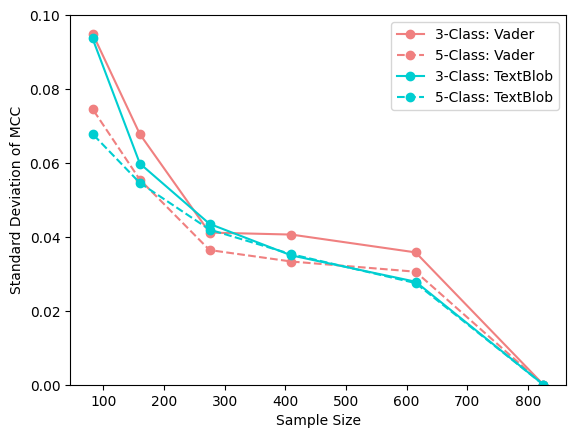

In [ ]:
tb3c = [0, np.std(out75["TextBlobMCCs_3c"]), np.std(out50["TextBlobMCCs_3c"]), np.std(out33["TextBlobMCCs_3c"]), np.std(out20["TextBlobMCCs_3c"]), np.std(out10["TextBlobMCCs_3c"])]
v3c = [0, np.std(out75["VaderMCCs_3c"]), np.std(out50["VaderMCCs_3c"]), np.std(out33["VaderMCCs_3c"]), np.std(out20["VaderMCCs_3c"]), np.std(out10["VaderMCCs_3c"])]
tb5c = [0, np.std(out75["TextBlobMCCs_5c"]), np.std(out50["TextBlobMCCs_5c"]), np.std(out33["TextBlobMCCs_5c"]), np.std(out20["TextBlobMCCs_5c"]), np.std(out10["TextBlobMCCs_5c"])]
v5c = [0, np.std(out75["VaderMCCs_5c"]), np.std(out50["VaderMCCs_5c"]), np.std(out33["VaderMCCs_5c"]), np.std(out20["VaderMCCs_5c"]), np.std(out10["VaderMCCs_5c"])]
sampleSize = [826, 615, 410, 275, 160, 82]





plt.plot(sampleSize, v3c, color='lightcoral', marker='o', label = "3-Class: Vader")
plt.plot(sampleSize, v5c, color='lightcoral', linestyle='dashed', marker='o', label = "5-Class: Vader")
plt.plot(sampleSize, tb3c, color='darkturquoise', marker='o', label = "3-Class: TextBlob")
plt.plot(sampleSize, tb5c, color='darkturquoise', linestyle='dashed', marker='o', label = "5-Class: TextBlob")
plt.xlabel("Sample Size")
plt.ylabel("Standard Deviation of MCC")
plt.ylim([0, 0.1])
plt.legend()

